# Method descriptions

* **global-reg** learn local clfs and a global one
* **lafond** 
* **regularised** learns local classifiers with laplacian constraint
* **local** learns independent local classifiers


In [14]:
# imports
from copy import deepcopy
import numpy as np
from statistics import mean

from sklearn.utils import shuffle

import sys
sys.path.append('../src/')

from classification import get_stumps
from evaluation import central_accuracy, edges
from network import synthetic_graph
from related_works import colearning, lafond_FW
from optimization import regularized_local_FW, async_regularized_local_FW, local_FW, global_regularized_local_FW, gd_reg_local_FW, centralized_FW
from utils import generate_models, generate_moons, get_min_max

import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
# set graph of nodes with local personalized data
NB_ITER = 200
N = 20
D = 20
B = 200
NOISE_R = 0.05
random_state = 2017
MU = 1
BETA = 10

MU_GD = 0.1
BETA_GD = 10

V, theta_true, cluster_indexes = generate_models(nb_clust=1, nodes_per_clust=N, random_state=random_state)
_, X, Y, X_test, Y_test, max_nb_instances = generate_moons(V, theta_true, D, random_state=random_state, sample_error_rate=NOISE_R)

# set graph
nodes, adj_matrix, similarities = synthetic_graph(X, Y, X_test, Y_test, V, theta_true, max_nb_instances)

# set callbacks for optimization analysis
callbacks = {
    'accuracy': [central_accuracy, []],
    'edges': [edges, []],
}

# get weak classifiers
vmin, vmax = get_min_max(X)
base_clfs = get_stumps(n=B, d=D+1, min_v=vmin, max_v=vmax)

results = {}

In [16]:
nodes_copy = deepcopy(nodes)
results["regularized"] = regularized_local_FW(nodes_copy, base_clfs, beta=BETA, nb_iter=NB_ITER, mu=MU, callbacks=callbacks)

In [17]:
# for p in [10, 40, 70]:
#     gd_nodes = deepcopy(nodes)
#     results["gd-regularized-{}".format(p)] = gd_reg_local_FW(gd_nodes, base_clfs, gd_method={"name":"laplacian", "pace_gd": p, "args":(1)}, beta=BETA_GD, mu=MU_GD, reset_step=False, nb_iter=NB_ITER, callbacks=callbacks)

In [18]:
lafond_nodes = deepcopy(nodes)
lafond_FW(lafond_nodes, base_clfs, beta=BETA_GD, nb_iter=1000, callbacks={})
results["lafond"] = central_accuracy(lafond_nodes)

centralized_nodes = deepcopy(nodes)
centralized_FW(centralized_nodes, base_clfs, beta=BETA, nb_iter=NB_ITER, callbacks={})
results["centralized"] = central_accuracy(centralized_nodes)

local_nodes = deepcopy(nodes)
local_FW(local_nodes, base_clfs, beta=BETA, nb_iter=NB_ITER, callbacks={})
results["local"] = central_accuracy(local_nodes)

global_nodes = deepcopy(nodes)
global_regularized_local_FW(global_nodes, base_clfs, beta=BETA, nb_iter=NB_ITER, callbacks={})
results["global-reg"] = central_accuracy(global_nodes)

results["colearning"], clf_colearning = colearning(N, X, Y, X_test, Y_test, D, NB_ITER, adj_matrix, similarities)

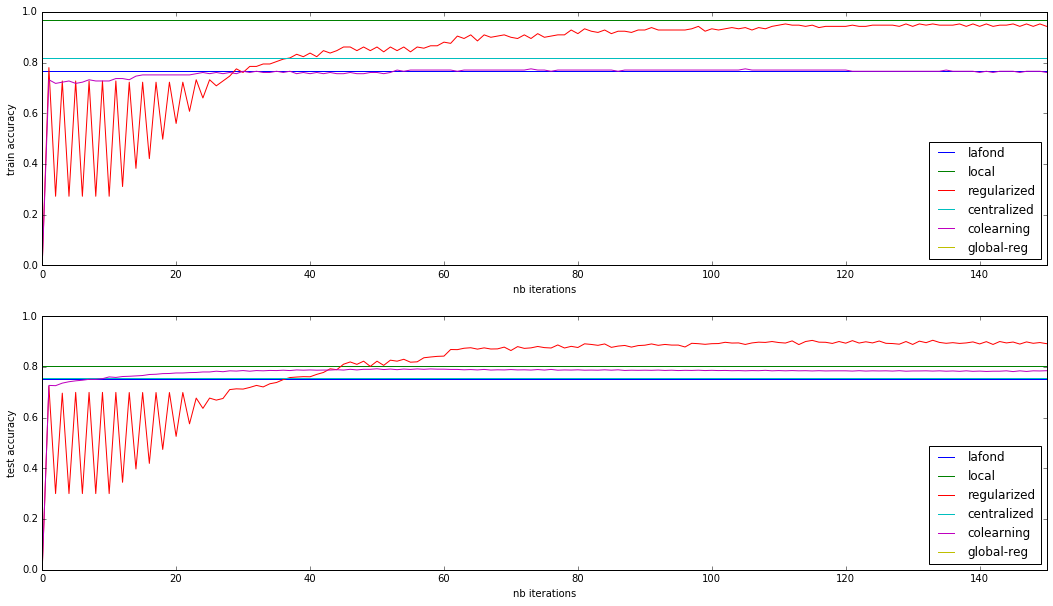

In [22]:
max_iter = 150
plt.figure(1, figsize=(18, 10))

plt.subplot(211)
plt.xlabel('nb iterations')
plt.ylabel('train accuracy')
plt.xlim(0, max_iter)

for k, r_list in results.items():
    try:
        plt.plot(range(len(r_list)), [r['accuracy'][0] for r in r_list], label='{}'.format(k))
    except:
        plt.plot(range(NB_ITER+1), [r_list[0]]*(NB_ITER+1), label='{}'.format(k))

plt.legend(loc='lower right')

plt.subplot(212)
plt.xlabel('nb iterations')
plt.ylabel('test accuracy')
plt.xlim(0, max_iter)

for k, r_list in results.items():
    try:
        plt.plot(range(len(r_list)), [r['accuracy'][1] for r in r_list], label='{}'.format(k))
    except:
        plt.plot(range(NB_ITER+1), [r_list[1]]*(NB_ITER+1), label='{}'.format(k))

plt.legend(loc='lower right')

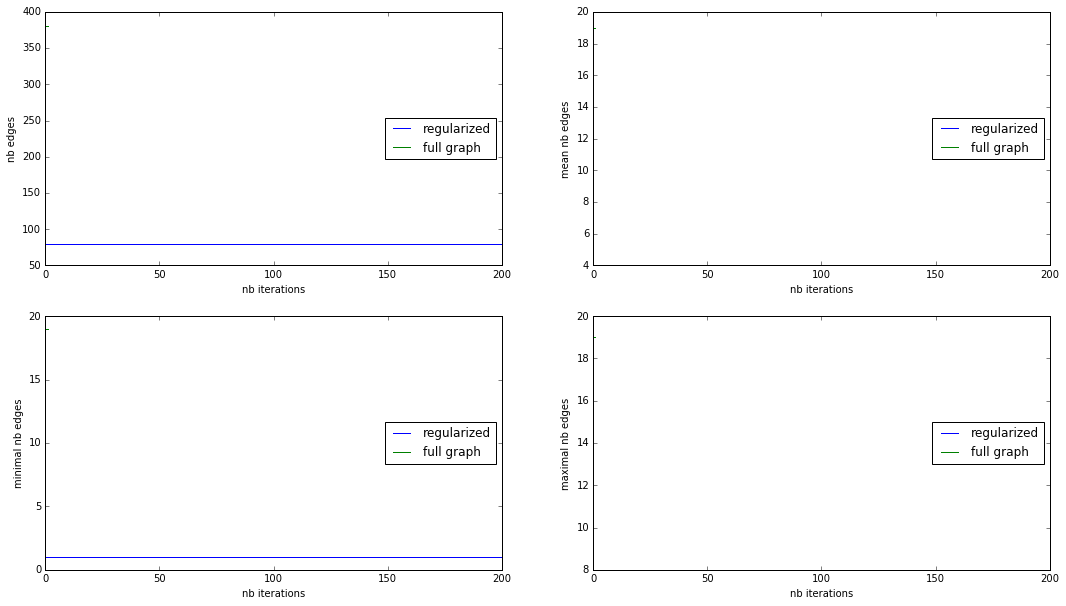

In [20]:
max_nb_edges = N*(N-1)

plt.figure(2, figsize=(18, 10))

plt.subplot(221)

plt.xlabel('nb iterations')
plt.ylabel('nb edges')

for k, r_list in results.items():
    try:
        plt.plot(range(len(r_list)), [sum(r['edges']) for r in r_list], label='{}'.format(k))
    except:
        pass

plt.plot(range(len(r_list)), [max_nb_edges]*len(r_list), label='full graph')

plt.legend(loc='center right')

plt.subplot(222)

plt.xlabel('nb iterations')
plt.ylabel('mean nb edges')

for k, r_list in results.items():
    try:
        plt.plot(range(len(r_list)), [mean(r['edges']) for r in r_list], label='{}'.format(k))
    except:
        pass

plt.plot(range(len(r_list)), [N-1]*len(r_list), label='full graph')

plt.legend(loc='center right')

plt.subplot(223)

plt.xlabel('nb iterations')
plt.ylabel('minimal nb edges')

for k, r_list in results.items():
    try:
        plt.plot(range(len(r_list)), [min(r['edges']) for r in r_list], label='{}'.format(k))
    except:
        pass

plt.plot(range(len(r_list)), [N-1]*len(r_list), label='full graph')


plt.legend(loc='center right')

plt.subplot(224)

plt.xlabel('nb iterations')
plt.ylabel('maximal nb edges')

for k, r_list in results.items():
    try:
        plt.plot(range(len(r_list)), [max(r['edges']) for r in r_list], label='{}'.format(k))
    except:
        pass

plt.plot(range(len(r_list)), [N-1]*len(r_list), label='full graph')

plt.legend(loc='center right')

In [21]:
print(results["gd-regularized-10"][NB_ITER]["adj-matrix"])


KeyError: 'gd-regularized-10'